# CS 180 Machine Project: Global Temperatures

The project aims to find an effective machine learning algorithm that can predict whether a Twitter user supports the belief in man-made climate change.

### Features
The features to be extracted are:
<br>
* Unigrams
* Bigrams
* Trigrams
<br>

### Model
The models to be used are:
<br>
* Support Vector Machine
* Decision Trees
<br>
<br>
---
! Run the cell below to load the libraries to be used in the project

In [57]:
import pandas as pd
import re
import string
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

### Data Import

The Twitter data comes from two datasets:
<br>
* Kaggle
* data.world
<br>

The Twitter sentiments needed are:
<br>
1. Pro
2. Anti
3. Neutral 
<br>
<br>
---
! Run the cell below to import the data

In [3]:
data1 = pd.read_csv("../data/kaggle_twitter_data.csv")
data2 = pd.read_csv("../data/dataworld_twitter_data.csv")

# Remove other columns
data1 = data1[["sentiment", "tweet"]]
data2 = data2[["sentiment", "tweet"]]

# Remove sentiment=2 from Kaggle data set
data1 = data1[data1.sentiment != 2]

frames = [data1, data2]

# All data
data = pd.concat(frames, ignore_index=True)

### Data Preprocessing

The data (the Tweet) is preprocessed such that:
1. Rows with NAN are dropped
2. Tweet is converted to string
3. Tweets are lowercased
4. Removes non-English Characters from the Tweet
5. Removes URLs from the Tweet
6. Removing RT and hyperlink from Tweet
7. Removes @ and # from Tweet
8. Remove stopwords from Tweet
9. Remove numbers from Tweet
10. Remove punctuations from Tweet
11. The Tweet is tokenized
12. The Tweet is lemmatized
<br>

After that, the preprocessed tweet is a new column to the dataset
<br>
---
! Run the cell below to preprocess the data

In [4]:
# Pre-processing
# Drop rows with NA or NAN
data = data.dropna()

df = data["tweet"]

# Make tweet to str
df = df.apply(str)

# Lowercase all words
df = df.apply(lambda x: x.lower())

# Remove non-English characters
df = df.apply(lambda x: x.encode("ascii", "ignore").decode())

# Remove URLS
df = df.apply(
    lambda x: re.sub(r"http?://[A-Za-z0-9./]+", "", x, flags=re.MULTILINE)
)
df = df.apply(
    lambda x: re.sub(r"https?://[A-Za-z0-9./]+", "", x, flags=re.MULTILINE)
)
df = df.apply(
    lambda x: re.sub(r"www?://[A-Za-z0-9./]+", "", x, flags=re.MULTILINE)
)

# Removing RT and link
df = df.apply(lambda x: re.sub(r"\bRT\b", "", x).strip())
df = df.apply(lambda x: re.sub(r"\blink\b", "", x).strip())

# Remove @ and #
df = df.apply(lambda x: re.sub(r"@[A-Za-z0-9_]+", "", x))
df = df.apply(lambda x: re.sub(r"#[A-Za-z0-9_]+", "", x))

# Remove stopwords
stop = stopwords.words("english")
df = df.apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

# Remove numbers
df = df.apply(lambda x: re.sub(r"[0-9]+", "", x))

# Remove punctuations
df = df.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenized
tokenizedTweets = [word_tokenize(x) for x in df]

# Lemmatize
lemmatizer = WordNetLemmatizer()
for tweet in tokenizedTweets:
    for word in tweet:
        word = lemmatizer.lemmatize(word)

processed = tokenizedTweets

# Append changed tweet to database
final = []
for x in range(len(processed)):
    final.append(" ".join(processed[x]))

out = pd.DataFrame(final)

data["changedtweet"] = out

### Splitting of Data

The data is split into three categories:
<br>
* Positive
* Negative
* Neutral
<br>

The first 5000 tweets in a category's dataset are to be used for testing and training.

For each category, the samples are split such that there are 60% tweets for training and 40% tweets for testing.
Therefore, for each category, there are:
<br>
* 3000 tweets for training
* 2000 tweets for testing
<br>
---
! Run the cell below to split the dataset

In [5]:
# 5000 samples per label
positive = data[data["sentiment"] == 1][:5000]
negative = data[data["sentiment"] == -1][:5000]
neutral = data[data["sentiment"] == 0][:5000]

#The features are extracted from the changed tweet and the target is the sentiment
features = ["changedtweet"]
targets = ["sentiment"]

#Create an empty Dataframe for features in train and test and sentiment in train and test
X_train = pd.DataFrame(columns = features)
X_test = pd.DataFrame(columns = features)
y_train = pd.DataFrame(columns = targets)
y_test = pd.DataFrame(columns = targets)

#Set an empty array to append the tweets
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for category in (positive, negative, neutral):
    X = category["changedtweet"]
    y = category["sentiment"]
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, random_state=0, train_size=0.6) #Split the dataset
    
    #Append the split data set to the array
    X_train_list.append(Xs_train)
    X_test_list.append(Xs_test)
    y_train_list.append(ys_train)
    y_test_list.append(ys_test)

#Concat the three categories to create one dataset
X_train = pd.concat(X_train_list, ignore_index=True)
X_test = pd.concat(X_test_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
y_test = pd.concat(y_test_list, ignore_index=True)

### Displaying of Top <i>n</i> Terms with the Highest TF-IDF Scores

To compare the effectiveness of unigrams, bigrams, and trigrams as features, the top n-grams with the highest TF-IDF scores are observed.

---
! Run the cell below to create a function that will display the top <i>n</i> terms with the highest TF-IDF scores

In [6]:
def display_top_n_scores(vectorizer, tfidf_result, n):
    print("Here are the top {} terms with the highest TF-IDF scores:".format(n))
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names_out(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

    for item in sorted_scores[:n]:
        print ("{0:50} Score: {1}".format(item[0], item[1]))

### Feature Extraction (Unigrams)

To extract the feature, use a TF-IDF vectorizer.
<br>
---
! Run the cell below to vectorize the tweets by unigrams, and to see the top 20 unigrams with the highest frequencies

In [7]:
#To extract the features use TF-IDF vectorizer
Tfidf_vect = TfidfVectorizer(ngram_range=(1,1)) #Unigram
Tfidf_vect.fit(data['changedtweet']) #Fit the vectorizer to the pre-processed tweets
Train_X_Tfidf = Tfidf_vect.transform(X_train) #Get the vectorized tweets for trainig
Test_X_Tfidf = Tfidf_vect.transform(X_test) #Get the vectorized tweets for testing

display_top_n_scores(Tfidf_vect, Train_X_Tfidf, 20)

Here are the top 20 terms with the highest TF-IDF scores:
rt                                                 Score: 464.8180387705098
climate                                            Score: 457.19713442234763
change                                             Score: 450.12761713238655
global                                             Score: 445.2623973558041
warming                                            Score: 440.5491615073265
believe                                            Score: 252.5883399915949
going                                              Score: 208.8780079248239
die                                                Score: 157.88403068424046
thinking                                           Score: 156.70479971372137
husband                                            Score: 153.81056541410138
trump                                              Score: 135.77853203835286
real                                               Score: 102.90316884634767
hoax                   

### SVM Algorithm for Unigrams

The SVM is set up with the hyperparameters:
<br>
* Kernel- Radial Basis Function
* Gamma- 1.3
* C- 1000
<br>

SVM Classification Report for Unigrams
              precision    recall  f1-score   support

          -1       0.63      0.55      0.59      2000
           0       0.51      0.78      0.62      2000
           1       0.98      0.59      0.73      2000

    accuracy                           0.64      6000
   macro avg       0.71      0.64      0.65      6000
weighted avg       0.71      0.64      0.65      6000

SVM Accuracy Score for Unigrams-> 64.0
SVM Precision Score for Unigrams-> 67.4366
SVM Recall Score for Unigrams-> 64.0
SVM F1 Score for Unigrams-> 63.2697

SVM Confusion Matrix for Unigrams


TypeError: Singleton array array(<6000x220633 sparse matrix of type '<class 'numpy.float64'>'
	with 49090 stored elements in Compressed Sparse Row format>, dtype=object) cannot be considered a valid collection.

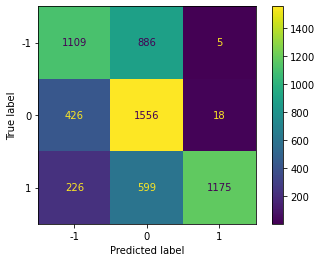

In [60]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='rbf', gamma=1.3, C=1000)
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Classification Report for Unigrams")
# Print the classification report
print(classification_report(y_test,predictions_SVM))

print("SVM Accuracy Score for Unigrams-> ", end="")
print(round(accuracy_score(predictions_SVM, y_test)*100,4))
print("SVM Precision Score for Unigrams-> ", end="")
print(round(precision_score(predictions_SVM, y_test, average='weighted')*100,4))
print("SVM Recall Score for Unigrams-> ", end="")
print(round(recall_score(predictions_SVM, y_test, average='weighted')*100,4))
print("SVM F1 Score for Unigrams-> ", end="")
print(round(f1_score(predictions_SVM, y_test, average='weighted')*100,4))

print()
print("SVM Confusion Matrix for Unigrams")
# Print the confusion matrix
ConfusionMatrixDisplay.from_estimator(SVM, Test_X_Tfidf, y_test)

cm=multilabel_confusion_matrix(Test_X_Tfidf, y_test, labels=SVM.classes_)
print(cm)

### Decision Tree Algorithm for Unigrams

The Decision Tree is set up with the hyperparameters:
<br>
* random state- 0
<br>

Decision Tree Classification Report for Unigrams
              precision    recall  f1-score   support

          -1       0.64      0.55      0.59      2000
           0       0.55      0.67      0.61      2000
           1       0.75      0.71      0.73      2000

    accuracy                           0.64      6000
   macro avg       0.65      0.64      0.64      6000
weighted avg       0.65      0.64      0.64      6000

Decision Tree Accuracy Score for Unigrams-> 64.2167
Decision Tree Precision Score for Unigrams-> 64.6938
Decision Tree Recall Score for Unigrams-> 64.2167
Decision Tree F1 Score for Unigrams-> 64.1277

Decision Tree Confusion Matrix for Unigrams


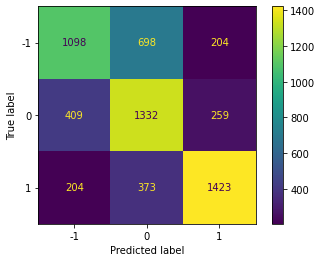

In [39]:
# Classifier - Algorithm - Decision Tree
# fit the training dataset on the classifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(Train_X_Tfidf, y_train)

# predict the labels on validation dataset
predictions_DecisionTree = dt.predict(Test_X_Tfidf)
print("Decision Tree Classification Report for Unigrams")

# Print the classification report
print(classification_report(y_test,predictions_DecisionTree))

print("Decision Tree Accuracy Score for Unigrams-> ", end="")
print(round(accuracy_score(predictions_DecisionTree, y_test)*100,4))
print("Decision Tree Precision Score for Unigrams-> ", end="")
print(round(precision_score(predictions_DecisionTree, y_test, average='weighted')*100,4))
print("Decision Tree Recall Score for Unigrams-> ", end="")
print(round(recall_score(predictions_DecisionTree, y_test, average='weighted')*100,4))
print("Decision Tree F1 Score for Unigrams-> ", end="")
print(round(f1_score(predictions_DecisionTree, y_test, average='weighted')*100,4))

print()
print("Decision Tree Confusion Matrix for Unigrams")
# Print the confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, Test_X_Tfidf, y_test)

### Feature Extraction (Bigrams)

To extract the feature, use TF-IDF vectorizer.
<br>
---
! Run the cell below to vectorize the tweets by bigrams, and to see the top 20 bigrams with the highest frequencies

In [43]:
#To extract the features use TF-IDF vectorizer
Tfidf_vect = TfidfVectorizer(ngram_range=(2,2)) #Bigrams
Tfidf_vect.fit(data['changedtweet']) #Fit the vectorizer to the pre-processed tweets
Train_X_Tfidf = Tfidf_vect.transform(X_train) #Get the vectorized tweets for trainig
Test_X_Tfidf = Tfidf_vect.transform(X_test) #Get the vectorized tweets for testing

display_top_n_scores(Tfidf_vect, Train_X_Tfidf, 20)

Here are the top 20 terms with the highest TF-IDF scores:
climate change                                     Score: 341.1373618467257
global warming                                     Score: 331.109056528575
believe climate                                    Score: 177.1833392869434
going die                                          Score: 132.61919808940232
rt thinking                                        Score: 132.19882001121715
die husband                                        Score: 131.5860426465852
thinking going                                     Score: 131.5860426465852
husband believe                                    Score: 131.53821712360204
rt presidentelect                                  Score: 52.25014325039279
change hoax                                        Score: 47.97916412507358
presidentelect believe                             Score: 44.74900365221551
going say                                          Score: 44.38395813000029
change millions             

### SVM Algorithm for Bigrams

The SVM is set up with the hyperparameters:
<br>
* Kernel- Radial Basis Function
* Gamma- 1.3
* C- 1000
<br>

SVM Classification Report for Bigrams
              precision    recall  f1-score   support

          -1       0.66      0.68      0.67      2000
           0       0.55      0.72      0.63      2000
           1       0.97      0.63      0.76      2000

    accuracy                           0.68      6000
   macro avg       0.73      0.68      0.69      6000
weighted avg       0.73      0.68      0.69      6000

SVM Accuracy Score for Bigrams-> 67.9
SVM Precision Score for Bigrams-> 68.9252
SVM Recall Score for Bigrams-> 67.9
SVM F1 Score for Bigrams-> 67.1229

SVM Confusion Matrix for Bigrams


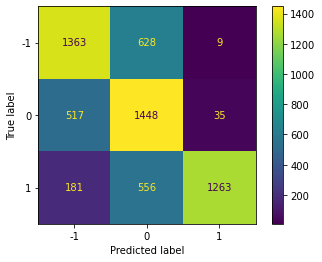

In [44]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='rbf', gamma=1.3, C=1000)
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Classification Report for Bigrams")

# Print the classification report
print(classification_report(y_test,predictions_SVM))


print("SVM Accuracy Score for Bigrams-> ", end="")
print(round(accuracy_score(predictions_SVM, y_test)*100,4))
print("SVM Precision Score for Bigrams-> ", end="")
print(round(precision_score(predictions_SVM, y_test, average='weighted')*100,4))
print("SVM Recall Score for Bigrams-> ", end="")
print(round(recall_score(predictions_SVM, y_test, average='weighted')*100,4))
print("SVM F1 Score for Bigrams-> ", end="")
print(round(f1_score(predictions_SVM, y_test, average='weighted')*100,4))

print()
print("SVM Confusion Matrix for Bigrams")
# Print the confusion matrix
ConfusionMatrixDisplay.from_estimator(SVM, Test_X_Tfidf, y_test)

### Decision Tree Algorithm for Bigrams

The Decision Tree is set up with the hyperparameters:
<br>
* random state- 0
<br>

Decision Tree Classification Report for Bigrams
              precision    recall  f1-score   support

          -1       0.69      0.39      0.50      2000
           0       0.50      0.78      0.61      2000
           1       0.82      0.72      0.77      2000

    accuracy                           0.63      6000
   macro avg       0.67      0.63      0.63      6000
weighted avg       0.67      0.63      0.63      6000

Decision Tree Accuracy Score for Bigrams-> 63.0167
Decision Tree Precision Score for Bigrams-> 69.0803
Decision Tree Recall Score for Bigrams-> 63.0167
Decision Tree F1 Score for Bigrams-> 63.5244

Decision Tree Confusion Matrix for Bigrams


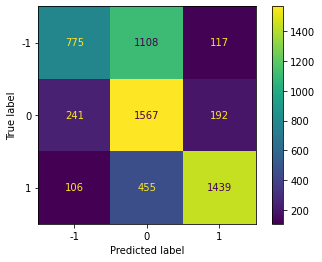

In [50]:
# Classifier - Algorithm - Decision Tree
# fit the training dataset on the classifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(Train_X_Tfidf, y_train)
# predict the labels on validation dataset
predictions_DecisionTree = dt.predict(Test_X_Tfidf)
print("Decision Tree Classification Report for Bigrams")
# Print the classification report
print(classification_report(y_test,predictions_DecisionTree))

print("Decision Tree Accuracy Score for Bigrams-> ", end="")
print(round(accuracy_score(predictions_DecisionTree, y_test)*100,4))
print("Decision Tree Precision Score for Bigrams-> ", end="")
print(round(precision_score(predictions_DecisionTree, y_test, average='weighted')*100,4))
print("Decision Tree Recall Score for Bigrams-> ", end="")
print(round(recall_score(predictions_DecisionTree, y_test, average='weighted')*100,4))
print("Decision Tree F1 Score for Bigrams-> ", end="")
print(round(f1_score(predictions_DecisionTree, y_test, average='weighted')*100,4))

print()
print("Decision Tree Confusion Matrix for Bigrams")
# Print the confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, Test_X_Tfidf, y_test)

### Feature Extraction (Trigrams)

To extract the feature, use TF-IDF vectorizer.
<br>
---
! Run the cell below to vectorize the tweets by trigrams, and to see the top 20 trigrams with the highest frequencies

In [51]:
#To extract the features use TF-IDF vectorizer
Tfidf_vect = TfidfVectorizer(ngram_range=(3,3)) #Unigram
Tfidf_vect.fit(data['changedtweet']) #Fit the vectorizer to the pre-processed tweets
Train_X_Tfidf = Tfidf_vect.transform(X_train) #Get the vectorized tweets for trainig
Test_X_Tfidf = Tfidf_vect.transform(X_test) #Get the vectorized tweets for testing

display_top_n_scores(Tfidf_vect, Train_X_Tfidf, 20)

Here are the top 20 terms with the highest TF-IDF scores:
believe climate change                             Score: 175.8943183597051
die husband believe                                Score: 131.95784142997653
going die husband                                  Score: 131.95784142997653
rt thinking going                                  Score: 131.95784142997653
thinking going die                                 Score: 131.95784142997653
husband believe climate                            Score: 131.90988077509888
climate change hoax                                Score: 46.67350023284448
presidentelect believe climate                     Score: 44.536754880959045
change millions people                             Score: 44.11778529831334
going say mr                                       Score: 44.11778529831334
millions people going                              Score: 44.11778529831334
people going say                                   Score: 44.11778529831334
climate change millions 

### SVM Algorithm for Trigrams

The SVM is set up with the hyperparameters:
<br>
* Kernel- Radial Basis Function
* Gamma- 1.3
* C- 1000
<br>

SVM Classification Report for Trigrams
              precision    recall  f1-score   support

          -1       0.63      0.55      0.59      2000
           0       0.51      0.78      0.62      2000
           1       0.98      0.59      0.73      2000

    accuracy                           0.64      6000
   macro avg       0.71      0.64      0.65      6000
weighted avg       0.71      0.64      0.65      6000

SVM Accuracy Score for Trigrams-> 64.0
SVM Precision Score for Trigrams-> 67.4366
SVM Recall Score for Trigrams-> 64.0
SVM F1 Score for Trigrams-> 63.2697

SVM Confusion Matrix for Trigrams


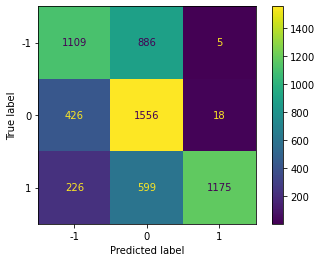

In [52]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='rbf', gamma=1.3, C=1000)
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Classification Report for Trigrams")
# Print the classification report
print(classification_report(y_test,predictions_SVM))


print("SVM Accuracy Score for Trigrams-> ", end="")
print(round(accuracy_score(predictions_SVM, y_test)*100,4))
print("SVM Precision Score for Trigrams-> ", end="")
print(round(precision_score(predictions_SVM, y_test, average='weighted')*100,4))
print("SVM Recall Score for Trigrams-> ", end="")
print(round(recall_score(predictions_SVM, y_test, average='weighted')*100,4))
print("SVM F1 Score for Trigrams-> ", end="")
print(round(f1_score(predictions_SVM, y_test, average='weighted')*100,4))

print()
print("SVM Confusion Matrix for Trigrams")
# Print the confusion matrix
ConfusionMatrixDisplay.from_estimator(SVM, Test_X_Tfidf, y_test)

### Decision Tree Algorithm for Trigrams

The Decision Tree is set up with the hyperparameters:
<br>
* random state- 0
<br>

Decision Tree Classification Report for Trigrams
              precision    recall  f1-score   support

          -1       0.69      0.39      0.50      2000
           0       0.50      0.78      0.61      2000
           1       0.82      0.72      0.77      2000

    accuracy                           0.63      6000
   macro avg       0.67      0.63      0.63      6000
weighted avg       0.67      0.63      0.63      6000

Decision Tree Accuracy Score for Trigrams-> 63.0167
Decision Tree Precision Score for Trigrams-> 69.0803
Decision Tree Recall Score for Trigrams-> 63.0167
Decision Tree F1 Score for Trigrams-> 63.5244

Decision Tree Confusion Matrix for Trigrams


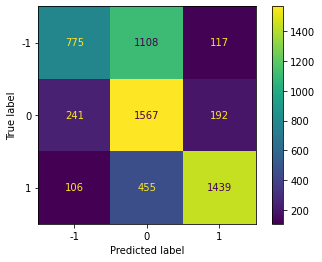

In [53]:
# Classifier - Algorithm - Decision Tree
# fit the training dataset on the classifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(Train_X_Tfidf, y_train)
# predict the labels on validation dataset
predictions_DecisionTree = dt.predict(Test_X_Tfidf)
print("Decision Tree Classification Report for Trigrams")
# Print the classification report
print(classification_report(y_test,predictions_DecisionTree))

print("Decision Tree Accuracy Score for Trigrams-> ", end="")
print(round(accuracy_score(predictions_DecisionTree, y_test)*100,4))
print("Decision Tree Precision Score for Trigrams-> ", end="")
print(round(precision_score(predictions_DecisionTree, y_test, average='weighted')*100,4))
print("Decision Tree Recall Score for Trigrams-> ", end="")
print(round(recall_score(predictions_DecisionTree, y_test, average='weighted')*100,4))
print("Decision Tree F1 Score for Trigrams-> ", end="")
print(round(f1_score(predictions_DecisionTree, y_test, average='weighted')*100,4))

print()
print("Decision Tree Confusion Matrix for Trigrams")
# Print the confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, Test_X_Tfidf, y_test)